In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.utils import data

### Import Data

In [45]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')

##### description

In [46]:
train_raw.shape, test_raw.shape

((1460, 81), (1459, 80))

In [47]:
train_raw.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


##### Concatenate the train and test data for standardisation

In [48]:
all_features_raw = pd.concat((train_raw.iloc[:,1:-1], test_raw.iloc[:,1:]))
all_features = all_features_raw.copy()

### Data Preprocessing

##### Standardisation

In [49]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x-x.mean())/(x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

##### Get Dummies

In [50]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

###### Convert to tensors

In [109]:
n_train = train_raw.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32).to(device)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_raw.SalePrice.values.reshape(-1,1), dtype=torch.float32).to(device)

### Training

##### Define loss function and model

##### We can experiement with the model. For example, the simplest can be a single nn.Linear model

In [110]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 64), nn.ReLU(), nn.Linear(64,1)).to(device)
    return net

##### Log root mean squared error

In [111]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

##### Load dataset

In [112]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

##### Define trainning model

In [113]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

##### K-fold cross-validation

In [114]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx,:], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [117]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

### Model Selection

In [150]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 1.3, 2, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.060504, valid log rmse 0.137651
fold 2, train log rmse 0.061839, valid log rmse 0.164960
fold 3, train log rmse 0.059367, valid log rmse 0.154080
fold 4, train log rmse 0.066540, valid log rmse 0.128201
fold 5, train log rmse 0.049740, valid log rmse 0.164462
5-fold validation: avg train log rmse: 0.059598, avg valid log rmse: 0.149871


##### The train_and_pred function doesn't use the k-fold validation. It makes sense since k-fold slipt the concatenated data.

In [151]:
def train_and_pred(train_features, test_features, train_labels, test_data, 
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    train_ls_all = []
    train_ls_all.append(train_ls)
    plt.plot(np.arange(1,101,1),train_ls_all[0])
    plt.xlabel('epoch'), plt.ylabel('rmse')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).cpu().detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.059983


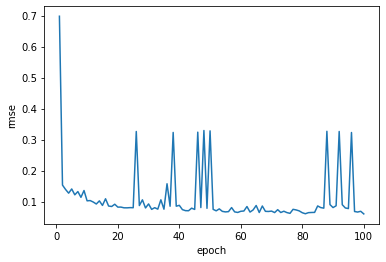

In [152]:
train_and_pred(train_features, test_features, train_labels, test_raw,
               num_epochs, lr, weight_decay, batch_size)

train log rmse 0.095216
train log rmse 0.057036
train log rmse 0.048914
train log rmse 0.055390
train log rmse 0.051434
train log rmse 0.087264
train log rmse 0.046050
train log rmse 0.056727
train log rmse 0.073113
train log rmse 0.089574
train log rmse 0.063307
train log rmse 0.062209
train log rmse 0.079727
train log rmse 0.326645
train log rmse 0.062816
train log rmse 0.123729
train log rmse 0.095543
train log rmse 0.095317
train log rmse 0.084934
train log rmse 0.098319
train log rmse 0.084774
train log rmse 0.107019
train log rmse 0.073643
train log rmse 0.116645
train log rmse 0.053792


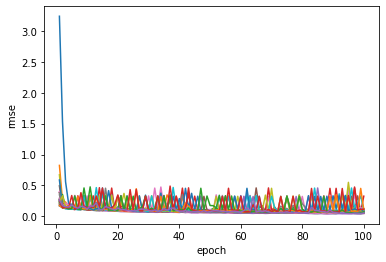

In [148]:
lr_range = np.arange(0.1, 5, 0.2).tolist()
for lr in lr_range:
    train_and_pred(train_features, test_features, train_labels, test_raw,
               num_epochs, lr, weight_decay, batch_size)

In [149]:
np.arange(0.1, 2, 0.2).tolist()

[0.1,
 0.30000000000000004,
 0.5000000000000001,
 0.7000000000000001,
 0.9000000000000001,
 1.1000000000000003,
 1.3000000000000003,
 1.5000000000000004,
 1.7000000000000004,
 1.9000000000000004]